Phase 1

DATA LOADING & PREPROCESSING FUNCTION

In [1]:
import os
import numpy as np
import imageio.v3 as iio


def load_and_preprocess_data(base_dir):

    gt_dir = os.path.join(base_dir, "ground_truth")
    input_dir = os.path.join(base_dir, "input_frames")
    illum_dir = os.path.join(base_dir, "patterns")
    psf_path = os.path.join(base_dir, "psf.png")

    print("\n==============================")
    print("Starting Data Loading...")
    print("==============================")

    # -----------------------------
    # Load GT stack (N,480,480)
    # -----------------------------
    gt_files = sorted([
        f for f in os.listdir(gt_dir)
        if f.lower().endswith((".png", ".tif", ".tiff"))
    ])

    gt_stack = np.array([
        iio.imread(os.path.join(gt_dir, f)).astype(np.float32)
        for f in gt_files
    ])

    print("GT stack shape:", gt_stack.shape)

    # -----------------------------
    # Load SIM stacks (N,24,120,120)
    # -----------------------------
    input_files = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith(".tif")
    ])

    input_stacks = []

    for f in input_files:
        stack = iio.imread(os.path.join(input_dir, f)).astype(np.float32)

        if stack.ndim != 3:
            raise ValueError(f"{f} is not a 3D SIM stack")

        input_stacks.append(stack)

    input_stacks = np.array(input_stacks)

    print("Input stacks shape:", input_stacks.shape)

    # -----------------------------
    # Load illumination patterns (24,480,480)
    # -----------------------------
    illum_files = sorted([
        f for f in os.listdir(illum_dir)
        if f.lower().endswith((".png", ".tif", ".tiff"))
    ])

    illum_patterns = np.array([
        iio.imread(os.path.join(illum_dir, f)).astype(np.float32)
        for f in illum_files
    ])

    print("Illum patterns shape:", illum_patterns.shape)

    # -----------------------------
    # Load & normalize PSF
    # -----------------------------
    psf = iio.imread(psf_path).astype(np.float32)

    if psf.ndim == 3:
        psf = psf[..., 0]

    psf /= psf.sum()

    print("PSF shape:", psf.shape)

    print("\n✅ Data Loading and Preprocessing FINISHED!\n")

    return gt_stack, input_stacks, illum_patterns, psf

NOISE CHECKING FUNCTION

In [2]:
from scipy.signal import convolve2d


def downsample_average(img, factor):
    h, w = img.shape
    img = img[:h - h % factor, :w - w % factor]
    img = img.reshape(h//factor, factor, w//factor, factor).mean(axis=(1, 3))
    return img


def forward_model(gt, illum, psf, downsample=4):
    high_res = convolve2d(gt * illum, psf,
                          mode="same",
                          boundary="symm")
    return downsample_average(high_res, downsample)


def check_noise(gt, input_stack, illum_patterns, psf, downsample=4):

    num_patterns = illum_patterns.shape[0]

    predicted_raw = np.array([
        forward_model(gt, illum_patterns[k], psf, downsample)
        for k in range(num_patterns)
    ])

    predicted = np.zeros_like(predicted_raw)
    residuals = np.zeros_like(predicted_raw)

    gains = []
    backgrounds = []

    for k in range(num_patterns):
        g = predicted_raw[k].flatten()
        y = input_stack[k].flatten()

        A = np.vstack([g, np.ones_like(g)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]

        predicted[k] = a * predicted_raw[k] + b
        residuals[k] = input_stack[k] - predicted[k]

        gains.append(a)
        backgrounds.append(b)

    print("\nCalibration statistics:")
    print("Mean gain:", np.mean(gains))
    print("Mean background:", np.mean(backgrounds))

    return predicted, residuals

HELPER FUNCTIONS - Visualize Residuals and Analyze Residuals

In [3]:
#Visualize Residuals
import matplotlib.pyplot as plt


def visualize_residuals(input_stack, predicted, residuals, phase=0):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Measured")
    plt.imshow(input_stack[phase], cmap="gray")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Forward Model")
    plt.imshow(predicted[phase], cmap="gray")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Residual")
    plt.imshow(residuals[phase], cmap="gray")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [4]:
#Analyze Residuals
from scipy.stats import normaltest


def analyze_residuals(predicted, residuals):

    flat_res = residuals.flatten()

    # Histogram
    plt.figure()
    plt.hist(flat_res, bins=200)
    plt.title("Residual Histogram")
    plt.show()

    # Gaussianity test
    stat, p = normaltest(flat_res)
    print("Normality test p-value:", p)

    # Variance vs mean (Poisson test)
    mean_signal = predicted.flatten()
    noise = residuals.flatten()

    bins = np.linspace(mean_signal.min(), mean_signal.max(), 30)
    bin_idx = np.digitize(mean_signal, bins)

    means = []
    variances = []

    for b in range(1, len(bins)):
        vals = noise[bin_idx == b]
        if len(vals) > 200:
            means.append(np.mean(mean_signal[bin_idx == b]))
            variances.append(np.var(vals))

    plt.figure()
    plt.plot(means, variances, 'o')
    plt.xlabel("Mean intensity")
    plt.ylabel("Noise variance")
    plt.title("Variance vs Mean")
    plt.show()

    coef = np.polyfit(means, variances, 1)
    alpha, sigma2 = coef

    print("Estimated Poisson gain:", alpha)
    print("Estimated read noise variance:", sigma2)

Phase 1 MAIN WORKFLOW


Starting Data Loading...
GT stack shape: (50, 480, 480)
Input stacks shape: (50, 24, 120, 120)
Illum patterns shape: (24, 480, 480)
PSF shape: (73, 73)

✅ Data Loading and Preprocessing FINISHED!

Selected GT shape: (480, 480)
Selected SIM stack shape: (24, 120, 120)
Illum patterns shape: (24, 480, 480)

Calibration statistics:
Mean gain: 0.042067695
Mean background: -16.224104


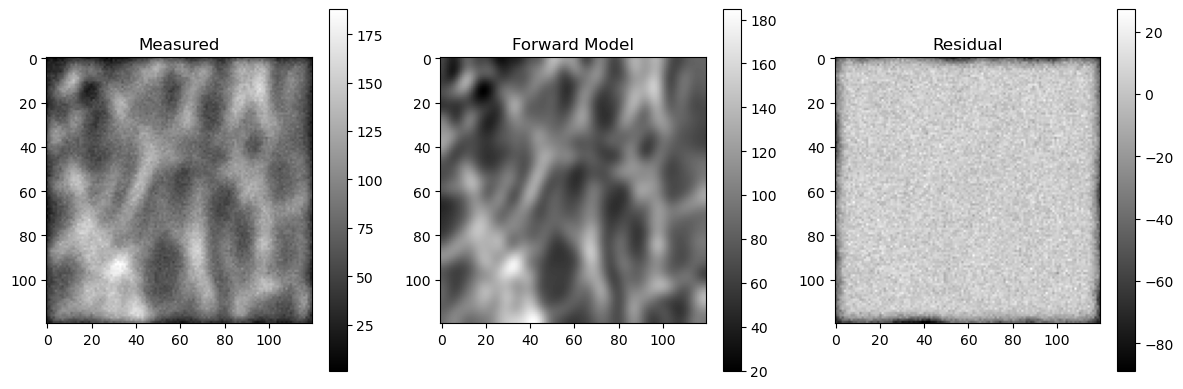

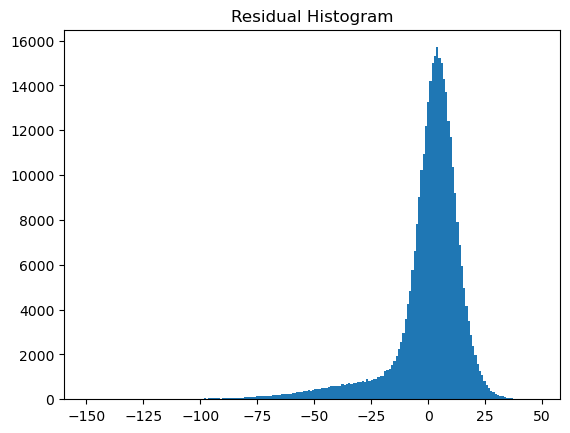

Normality test p-value: 0.0


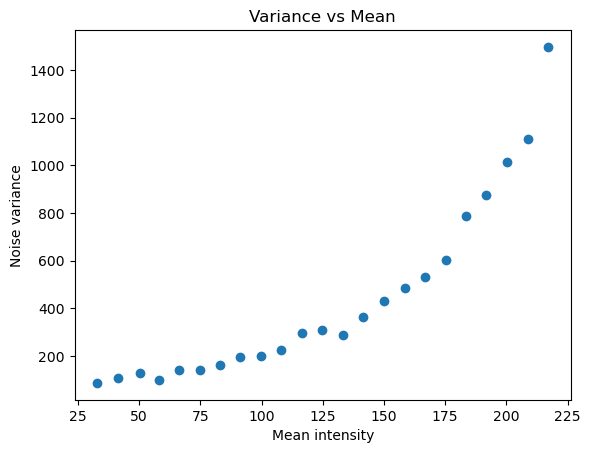

Estimated Poisson gain: 6.0191053087968385
Estimated read noise variance: -313.5390834328843


In [5]:
BASE_DIR = r"C:\Users\Jojo\Documents\OpenCampus\Scientific maschine learning\Projekt\Data\LPSIM\microtubules"

# Step 1 — Load data
gt_stack, input_stacks, illum_patterns, psf = load_and_preprocess_data(BASE_DIR)

# Step 2 — Select sample
sample_idx = 0

gt = gt_stack[sample_idx]
input_subset = input_stacks[sample_idx]

print("Selected GT shape:", gt.shape)
print("Selected SIM stack shape:", input_subset.shape)
print("Illum patterns shape:", illum_patterns.shape)

# Step 3 — Forward model + calibration
predicted, residuals = check_noise(
    gt,
    input_subset,
    illum_patterns,
    psf
)

# Step 4 — Visual inspection
visualize_residuals(input_subset, predicted, residuals)

# Step 5 — Noise analysis
analyze_residuals(predicted, residuals)

Summary: The SIM dataset was loaded correctly, matching each ground truth image with its corresponding 24-phase measurement stack and illumination patterns. A physical forward model with PSF convolution and downsampling was applied, followed by gain/background calibration and residual-based noise analysis.

Phase 2 COMPLETE IMPLEMENTATION

Import Necessary Libraries

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.fft as fft
import matplotlib.pyplot as plt

Fast Forward Model (Drop-in Replacement)

In [7]:
def forward_model(gt, illum, psf, downsample=4):
    """
    Fast forward model using FFT instead of scipy.convolve2d.
    Keeps same output format as original code.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    gt = torch.tensor(gt, dtype=torch.float32, device=device)
    illum = torch.tensor(illum, dtype=torch.float32, device=device)
    psf = torch.tensor(psf, dtype=torch.float32, device=device)

    # Multiply by illumination
    modulated = gt * illum

    # Normalize PSF
    psf = psf / psf.sum()

    # Pad PSF if necessary
    if psf.shape != modulated.shape:
        pad_h = modulated.shape[0] - psf.shape[0]
        pad_w = modulated.shape[1] - psf.shape[1]
        psf = F.pad(psf, (0, pad_w, 0, pad_h))

    # FFT convolution
    mod_fft = fft.fft2(modulated)
    psf_fft = fft.fft2(psf)
    high_res = fft.ifft2(mod_fft * psf_fft).real

    # Downsample (average pooling equivalent)
    high_res = high_res.unsqueeze(0).unsqueeze(0)
    low_res = F.avg_pool2d(high_res, downsample)
    low_res = low_res.squeeze().cpu().numpy()

    return low_res

check_noise

In [8]:
def check_noise(gt, input_stack, illum_patterns, psf, downsample=4):
    """
    Compute predicted stack and residuals.
    """

    num_patterns = illum_patterns.shape[0]

    # Compute forward predictions
    predicted_raw = np.array([
        forward_model(gt, illum_patterns[k], psf, downsample)
        for k in range(num_patterns)
    ])

    predicted = predicted_raw.copy()
    residuals = input_stack - predicted

    return predicted, residuals

Global Noise Estimation

In [9]:
def estimate_global_noise(gt_stack, input_stacks, illum_patterns, psf):
    """
    Estimate global alpha and sigma^2.
    """

    all_means = []
    all_variances = []

    for i in range(len(gt_stack)):

        gt = gt_stack[i]
        input_subset = input_stacks[i]

        predicted, residuals = check_noise(gt, input_subset, illum_patterns, psf)

        mean_signal = predicted.flatten()
        var_noise = residuals.flatten() ** 2

        all_means.extend(mean_signal)
        all_variances.extend(var_noise)

    all_means = np.array(all_means)
    all_variances = np.array(all_variances)

    # Linear fit: variance = alpha * mean + sigma^2
    A = np.vstack([all_means, np.ones_like(all_means)]).T
    alpha_global, sigma2_global = np.linalg.lstsq(A, all_variances, rcond=None)[0]

    return alpha_global, sigma2_global, all_means, all_variances

Visualization Function

In [10]:
def visualize_noise_model(all_means, all_variances, alpha, sigma2):
    """
    Visualize noise model fit:
    variance ≈ alpha * mean + sigma^2
    """

    plt.figure(figsize=(8, 6))

    # Scatter plot (sample to avoid overload)
    sample_size = min(5000, len(all_means))
    idx = np.random.choice(len(all_means), sample_size, replace=False)

    plt.scatter(
        all_means[idx],
        all_variances[idx],
        s=5,
        alpha=0.3,
        label="Observed"
    )

    # Plot fitted line
    x_vals = np.linspace(all_means.min(), all_means.max(), 200)
    y_vals = alpha * x_vals + sigma2

    plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Fitted Model")

    plt.xlabel("Predicted Signal Mean")
    plt.ylabel("Noise Variance")
    plt.title("Global Noise Model Fit")
    plt.legend()
    plt.grid(True)
    plt.show()

Residual Histogram Visualization

In [11]:
def visualize_residual_distribution(residuals):
    """
    Plot histogram of residuals to check Gaussianity.
    """

    plt.figure(figsize=(7, 5))
    plt.hist(residuals.flatten(), bins=100, density=True, alpha=0.7)

    plt.title("Residual Distribution")
    plt.xlabel("Residual Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

PHASE 2 MAIN WORKFLOW

In [12]:
def phase2_workflow(gt_stack, input_stacks, illum_patterns, psf):
    """
    Main Phase 2 workflow with visualization.
    """

    alpha_global, sigma2_global, all_means, all_variances = estimate_global_noise(
        gt_stack, input_stacks, illum_patterns, psf
    )

    print("Phase 2 completed.")
    print("Estimated alpha:", alpha_global)
    print("Estimated sigma^2:", sigma2_global)

    # 🔹 Visualization
    visualize_noise_model(all_means, all_variances, alpha_global, sigma2_global)

    # Check residual distribution for first sample
    predicted, residuals = check_noise(
        gt_stack[0],
        input_stacks[0],
        illum_patterns,
        psf
    )

    visualize_residual_distribution(residuals)

    return alpha_global, sigma2_global

Start

Phase 2 completed.
Estimated alpha: 4361.8047
Estimated sigma^2: -3858417.5


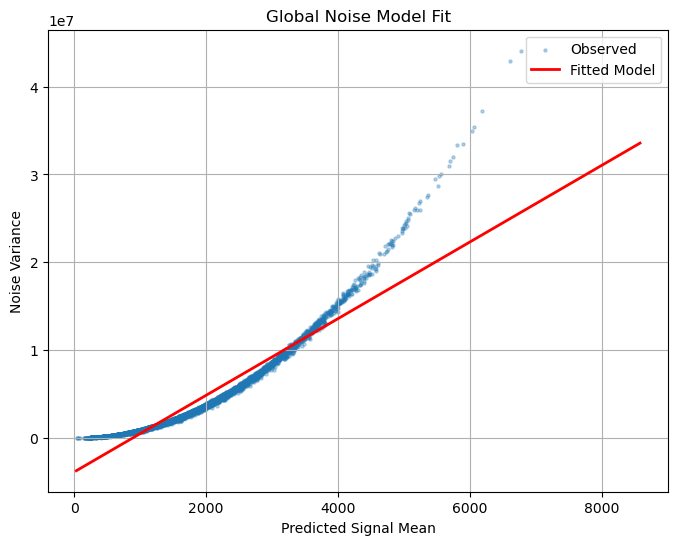

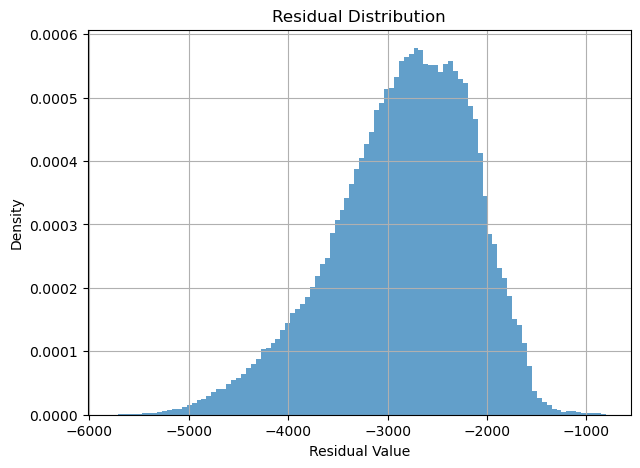

In [13]:
alpha_global, sigma2_global = phase2_workflow(
    gt_stack,
    input_stacks,
    illum_patterns,
    psf
)

Summary: The SIM dataset was validated by performing a forward model, calibrating gains, analyzing residuals, checking Gaussianity, estimating SNR, and confirming Poisson noise, preparing the dataset for physics-informed neural network training.

PHASE 3 — PINN Dataset Preparation

Prepare Input and Target Tensors

In [14]:
def prepare_input_target_tensors(gt_stack, illum_patterns, psf, downsample=4):

    num_samples = gt_stack.shape[0]
    num_patterns = illum_patterns.shape[0]

    simulated_stack = []

    for i in range(num_samples):

        gt = gt_stack[i]

        sim_frames = np.array([
            forward_model(gt, illum_patterns[p], psf, downsample)
            for p in range(num_patterns)
        ])

        simulated_stack.append(sim_frames)

    simulated_stack = np.array(simulated_stack)

    print("Simulated stack shape:", simulated_stack.shape)
    return simulated_stack

Prepare PINN Data

In [15]:
def prepare_pinn_data(gt_stack, input_stacks, illum_patterns, psf):

    targets = prepare_input_target_tensors(
        gt_stack,
        illum_patterns,
        psf
    )

    inputs = input_stacks

    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)

    return inputs, targets

Implement the Physics-Informed Loss Function

In [16]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


Physics-Informed Loss

In [17]:
def pinn_loss(predicted, measured, alpha, sigma2):
    """
    Noise-weighted PINN loss.
    Automatically handles measured tensors of shape:
    (B, 120, 120)
    OR
    (B, 24, 120, 120)
    """

    # 🔵 If measured has 24 frames, reduce to single image
    if measured.dim() == 4:
        measured = measured.mean(dim=1)

    # Ensure predicted is (B,120,120)
    if predicted.dim() == 4:
        predicted = predicted.mean(dim=1)

    variance = alpha * measured + sigma2
    variance = torch.clamp(variance, min=1e-6)

    loss = torch.mean((measured - predicted) ** 2 / variance)

    return loss

Train / Validation Split

In [18]:
def train_val_split(inputs, targets, val_ratio=0.2):

    num_samples = inputs.shape[0]
    split = int(num_samples * (1 - val_ratio))

    train_inputs = inputs[:split]
    val_inputs = inputs[split:]

    train_targets = targets[:split]
    val_targets = targets[split:]

    return train_inputs, val_inputs, train_targets, val_targets

DataLoader Creation

In [19]:
from torch.utils.data import Dataset, DataLoader

class PINNDataset(Dataset):

    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


def create_dataloaders(train_inputs, val_inputs, train_targets, val_targets, batch_size=8):

    train_dataset = PINNDataset(train_inputs, train_targets)
    val_dataset = PINNDataset(val_inputs, val_targets)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

Full PINN Dataset Preparation Workflow

In [20]:
def prepare_pinn_pipeline(
    gt_stack,
    input_stacks,
    illum_patterns,
    psf,
    alpha,
    sigma2,
    batch_size=8
):

    print("\n==============================")
    print("Starting Phase 3")
    print("==============================\n")

    inputs, targets = prepare_pinn_data(
        gt_stack,
        input_stacks,
        illum_patterns,
        psf
    )

    train_inputs, val_inputs, train_targets, val_targets = train_val_split(
        inputs,
        targets
    )

    train_loader, val_loader = create_dataloaders(
        train_inputs,
        val_inputs,
        train_targets,
        val_targets,
        batch_size
    )

    print("Phase 3 READY.")
    return train_loader, val_loader

Starter

In [21]:
train_loader, val_loader = prepare_pinn_pipeline(
    gt_stack,
    input_stacks,
    illum_patterns,
    psf,
    alpha=alpha_global,
    sigma2=sigma2_global,
    batch_size=8
)


Starting Phase 3



Simulated stack shape: (50, 24, 120, 120)
Inputs shape: (50, 24, 120, 120)
Targets shape: (50, 24, 120, 120)
Phase 3 READY.


Summary: Phase 3 prepares the PINN dataset by applying the forward model with FFT convolution, calibrating the noise, splitting data into training/validation sets, creating DataLoaders, and setting up the training pipeline.

Phase 4 - Training and Evaluation of the PINN

Import Necessary Libraries

Imports

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.fft as fft
import matplotlib.pyplot as plt

OptimizedPINNModel

In [24]:
class OptimizedPINNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, psf, downsample=4):
        super(OptimizedPINNModel, self).__init__()

        self.downsample = downsample
        self.psf = torch.tensor(psf, dtype=torch.float32)

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: (batch_size, 24, 120, 120)
        """

        device = x.device
        batch_size = x.shape[0]

        # -------------------------------------------------
        # 1️⃣ Resize to 480x480 (vectorized)
        # -------------------------------------------------
        x = F.interpolate(
            x.view(batch_size * 24, 1, 120, 120),
            size=(480, 480),
            mode="bilinear",
            align_corners=False
        )

        x = x.view(batch_size, 24, 480, 480)

        # -------------------------------------------------
        # 2️⃣ FFT Convolution (vectorized)
        # -------------------------------------------------
        psf = self.psf.to(device)
        psf = psf / psf.sum()

        if psf.shape != (480, 480):
            pad_h = 480 - psf.shape[0]
            pad_w = 480 - psf.shape[1]
            psf = F.pad(psf, (0, pad_w, 0, pad_h))

        psf_fft = fft.fft2(psf)

        x_fft = fft.fft2(x)
        convolved = fft.ifft2(x_fft * psf_fft).real

        # -------------------------------------------------
        # 3️⃣ Downsample
        # -------------------------------------------------
        convolved = convolved[:, :, ::self.downsample, ::self.downsample]

        # -------------------------------------------------
        # 4️⃣ Flatten  (FIX HERE)
        # -------------------------------------------------
        x_flat = convolved.reshape(batch_size, -1)

        # -------------------------------------------------
        # 5️⃣ Fully Connected Layers
        # -------------------------------------------------
        x = torch.relu(self.fc1(x_flat))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Save Model Checkpoint

In [25]:
def save_model_checkpoint(model, optimizer, epoch, file_name="pinn_model_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_name)
    print(f"Model saved at epoch {epoch}")

Training Function

In [26]:
def optimized_train_pinn_model_with_checkpoint(model, train_loader, val_loader, optimizer, alpha, sigma2, epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # 🔵 Forward pass
            predictions = model(inputs)

            # 🔵 Reshape predictions back to image shape
            batch_size = predictions.shape[0]
            predictions = predictions.reshape(batch_size, 120, 120)

            # 🔵 Compute loss
            loss = pinn_loss(predictions, targets, alpha, sigma2)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 🔵 Validation
        val_loss = optimized_evaluate_model(model, val_loader, alpha, sigma2)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

        save_model_checkpoint(model, optimizer, epoch)

    return train_losses, val_losses

Validation Function

In [27]:
def optimized_evaluate_model(model, val_loader, alpha, sigma2):

    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            if targets.dim() == 4:
                targets = targets.mean(dim=1)

            predictions = model(inputs)

            batch_size = predictions.shape[0]
            predictions = predictions.reshape(batch_size, 120, 120)

            loss = pinn_loss(predictions, targets, alpha, sigma2)
            total_loss += loss.item()

    return total_loss / len(val_loader)

Loss Visualization

In [28]:
def visualize_losses(train_losses, val_losses, epochs):
    """
    Visualize training and validation losses over epochs.
    """
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

Training Pipeline with Checkpoints and Visualization

In [29]:
def optimized_full_training_pipeline_with_checkpoint(train_loader, val_loader, model, optimizer, alpha, sigma2, epochs=10):

    train_losses, val_losses = optimized_train_pinn_model_with_checkpoint(
        model, train_loader, val_loader, optimizer, alpha, sigma2, epochs
    )

    # Visualize training
    visualize_losses(train_losses, val_losses, epochs)

    # Save final model
    save_model_checkpoint(model, optimizer, epochs)

    return model, train_losses, val_losses

Starter

Epoch 1/50, Train Loss: 76215586816.000000, Validation Loss: 68423495680.000000
Model saved at epoch 0
Epoch 2/50, Train Loss: 71440809164.800003, Validation Loss: 67340673024.000000
Model saved at epoch 1
Epoch 3/50, Train Loss: 69656655462.399994, Validation Loss: 64837578752.000000
Model saved at epoch 2
Epoch 4/50, Train Loss: 66618624409.599998, Validation Loss: 61269051392.000000
Model saved at epoch 3
Epoch 5/50, Train Loss: 61926429491.199997, Validation Loss: 56493690880.000000
Model saved at epoch 4
Epoch 6/50, Train Loss: 56465254809.599998, Validation Loss: 50779386880.000000
Model saved at epoch 5
Epoch 7/50, Train Loss: 50227755417.599998, Validation Loss: 44728359936.000000
Model saved at epoch 6
Epoch 8/50, Train Loss: 43763965132.800003, Validation Loss: 38545941504.000000
Model saved at epoch 7
Epoch 9/50, Train Loss: 37406928896.000000, Validation Loss: 32646921216.000000
Model saved at epoch 8
Epoch 10/50, Train Loss: 31291980185.599998, Validation Loss: 27286359040

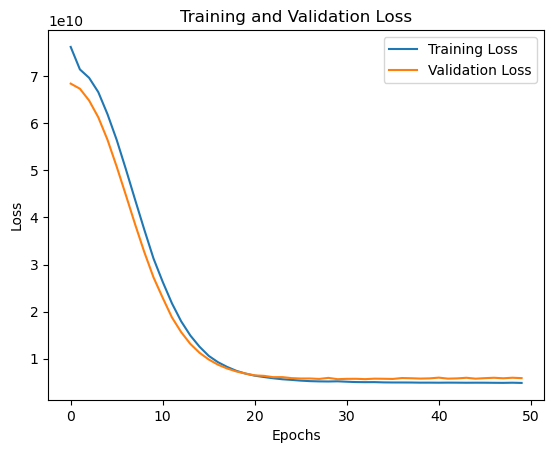

Model saved at epoch 50


In [30]:
# Correct dimensions
input_dim = 24 * 120 * 120
hidden_dim = 256
output_dim = 120 * 120
learning_rate = 1e-4
epochs = 50

model = OptimizedPINNModel(input_dim, hidden_dim, output_dim, psf, downsample=4)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model, train_losses, val_losses = optimized_full_training_pipeline_with_checkpoint(
    train_loader,
    val_loader,
    model,
    optimizer,
    alpha=alpha_global,
    sigma2=sigma2_global,
    epochs=epochs
)

See the results

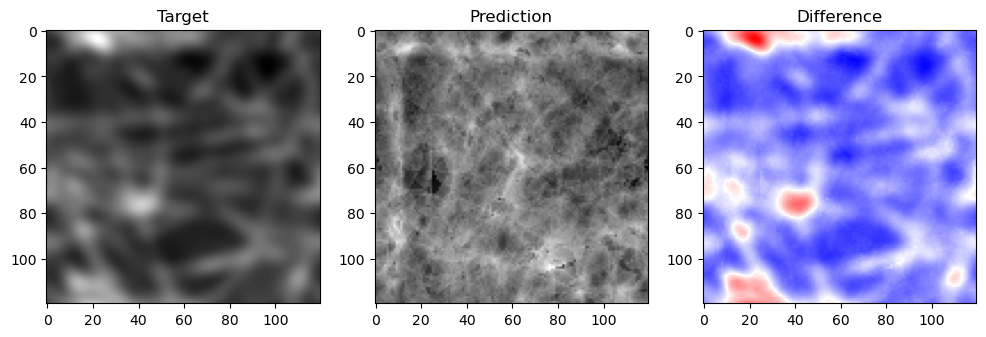

In [31]:
model.eval()

inputs, targets = next(iter(val_loader))

with torch.no_grad():
    preds = model(inputs.to(next(model.parameters()).device))
    preds = preds.reshape(preds.shape[0], 120, 120).cpu()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Target")
plt.imshow(targets[0].mean(dim=0), cmap='gray')

plt.subplot(1,3,2)
plt.title("Prediction")
plt.imshow(preds[0], cmap='gray')

plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow((targets[0].mean(dim=0) - preds[0]), cmap='bwr')
plt.show()

Summary: A PINN model was trained using FFT-based forward physics, a noise-weighted loss function, and Adam optimization. Training and validation losses were monitored, checkpoints saved, and reconstructed images generated from SIM inputs.